https://www.kaggle.com/mirichoi0218/insurance

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mutual_info_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

%matplotlib inline

In [2]:
data = pd.read_csv('insurance.csv')

In [3]:
profile = ProfileReport(data, title="Pandas Profiling Report", explorative=True)

In [4]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# data preparation
The dataset is clean. All feature names are lower case without spaces. There are no missing values. One row is duplicated, but to me it seems possible that there are two 19 year olds with a bmi of 30.59 in the northwest. Since the features are the same, it also seems to make sense that they are paying the same.

If we would need to clean the column names, we could use:
> data.columns = data.columns.str.lower().str.replace(' ', '_')

For imputing missing values, we could use, e.g., the simple imputer from sklearn:
> from sklearn.impute import SimpleImputer
> imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

The stragegy would depend on the feature. Or if few values would be missing we could simply drop the rows.

# data analysis

In [6]:
# keep the ratio of smokers constant
df_train, df_test = train_test_split(data, test_size=0.2, random_state=1, stratify=data['smoker'])

# no validation set needed, because we use crossvalidation
# df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, stratify=df_full_train['smoker'])

In [7]:
df_train.groupby('smoker')['age'].count() / df_train.shape[0]

smoker
no     0.795327
yes    0.204673
Name: age, dtype: float64

In [8]:
df_test.groupby('smoker')['age'].count() / df_test.shape[0]

smoker
no     0.794776
yes    0.205224
Name: age, dtype: float64

In [9]:
df_train['smoker'].value_counts()

no     851
yes    219
Name: smoker, dtype: int64

In [10]:
df_train['region'].value_counts()

southeast    288
northeast    264
northwest    261
southwest    257
Name: region, dtype: int64

In [11]:
df_train['sex'].value_counts()

male      549
female    521
Name: sex, dtype: int64

In [12]:
df_train['children'].value_counts()

0    458
1    260
2    196
3    123
4     21
5     12
Name: children, dtype: int64

In [28]:
categorical_features = ['smoker', 'sex', 'region', 'children']

Thre are three categorical variables, region, sex and smoker. Children can be used as categorical or numerical feature. We can investigate later if this makes a difference.

target variable

<AxesSubplot:>

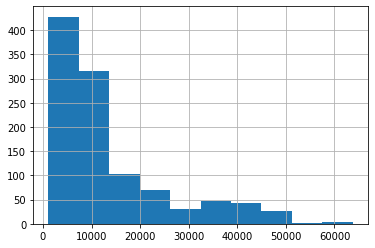

In [13]:
df_train['charges'].hist()

<AxesSubplot:>

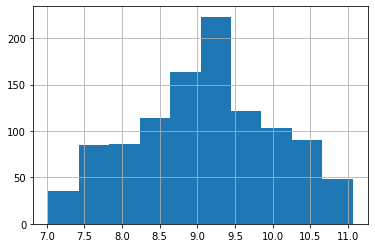

In [14]:
# log transform to get a better distribution of the target variable
df_train['charges'] = np.log1p(df_train['charges'])
df_test['charges'] = np.log1p(df_test['charges'])
df_train['charges'].hist()

check correlations between the numeric features

<AxesSubplot:>

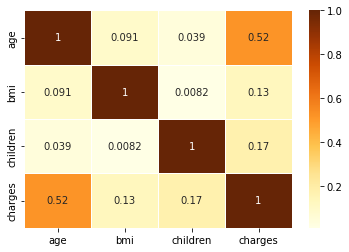

In [15]:
sns.heatmap(df_train.corr(), linewidths=0.5, annot=True, cmap='YlOrBr')

smoker

<AxesSubplot:>

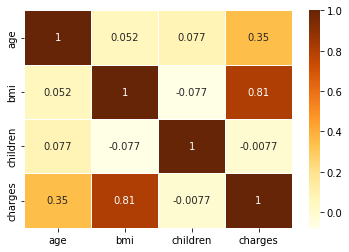

In [16]:
sns.heatmap(df_train[df_train['smoker'] == 'yes'].corr(), linewidths=0.5, annot=True, cmap='YlOrBr')

<AxesSubplot:>

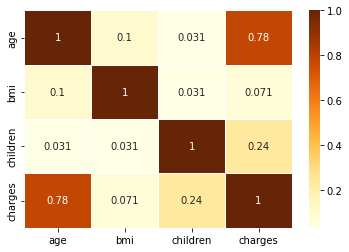

In [17]:
sns.heatmap(df_train[df_train['smoker'] == 'no'].corr(), linewidths=0.5, annot=True, cmap='YlOrBr')

In [18]:
df_train.groupby('smoker').agg(['mean', 'count'])

age              bmi        children          charges      
             mean count       mean count      mean count       mean count
smoker                                                                   
no      39.340776   851  30.674072   851  1.068155   851   8.794622   851
yes     38.493151   219  30.848425   219  1.168950   219  10.318829   219

There are a lot more non smokers in the dataset. If a person is a smoker or not seems to be a very important feature. For modelling the data, we should be splitting the data in such a way that the distribution is similar in the training and evaluation set.

sex

<AxesSubplot:>

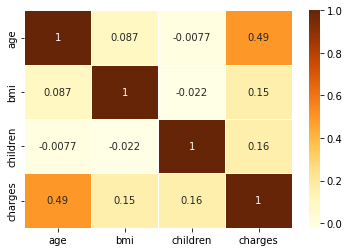

In [19]:
sns.heatmap(df_train[df_train['sex'] == 'male'].corr(), linewidths=0.5, annot=True, cmap='YlOrBr')

<AxesSubplot:>

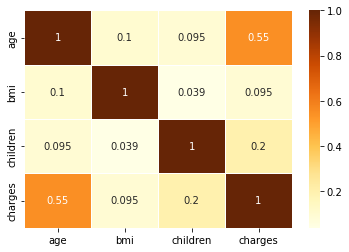

In [20]:
sns.heatmap(df_train[df_train['sex'] == 'female'].corr(), linewidths=0.5, annot=True, cmap='YlOrBr')

In [21]:
df_train.groupby('sex').agg(['mean', 'count'])

age              bmi        children         charges      
             mean count       mean count      mean count      mean count
sex                                                                     
female  39.667946   521  30.415768   521  1.059501   521  9.103321   521
male    38.692168   549  30.988752   549  1.116576   549  9.109684   549

region

In [22]:
df_train.groupby('region').agg(['mean', 'count'])

age              bmi        children         charges      
                mean count       mean count      mean count      mean count
region                                                                     
northeast  39.132576   264  29.056686   264  1.053030   264  9.161484   264
northwest  39.237548   261  29.156264   261  1.145594   261  9.066602   261
southeast  39.149306   288  33.545799   288  1.031250   288  9.181831   288
southwest  39.151751   257  30.807393   257  1.132296   257  9.006477   257

region: southeast, average bmi: 33.55,           samples: 288


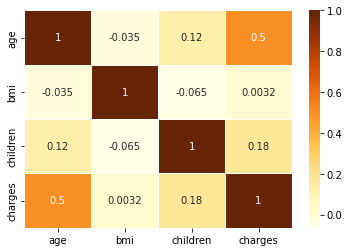

region: northwest, average bmi: 29.16,           samples: 261


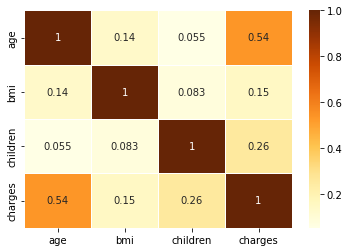

region: northeast, average bmi: 29.06,           samples: 264


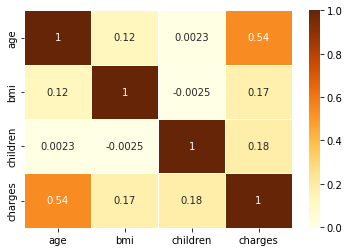

region: southwest, average bmi: 30.81,           samples: 257


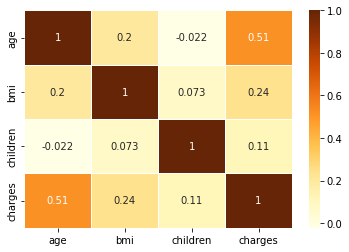

In [25]:
for region in df_train['region'].unique():
    print(f'region: {region}, average bmi: {df_train[df_train["region"] == region]["bmi"].mean():.2f}, \
          samples: {df_train[df_train["region"] == region].shape[0]}')
    sns.heatmap(df_train[df_train['region'] == region].corr(), linewidths=0.5, annot=True, cmap='YlOrBr')
    plt.pause(0.1)

children

In [24]:
df_train.groupby('children').agg(['mean', 'count'])

age              bmi         charges      
               mean count       mean count      mean count
children                                                  
0         38.500000   458  30.656288   458  8.940916   458
1         39.211538   260  30.774019   260  9.072611   260
2         39.515306   196  30.549413   196  9.332183   196
3         41.528455   123  31.028862   123  9.393487   123
4         38.714286    21  31.097381    21  9.421655    21
5         34.583333    12  30.027917    12  8.988900    12

check correlations between the numeric features

In [26]:
# divide the targed variable in 10 groups with similar amount of members
charges_groups = pd.qcut(df_train['charges'], q=10)

In [29]:
for cat_feature in categorical_features:
    print(f'{cat_feature:<8} {mutual_info_score(df_train[cat_feature], charges_groups)}')

smoker   0.35521723291357865
sex      0.011900883353382463
region   0.02170410831195324
children 0.11550802403202476


If a person is a smoker or not seems to be the most important feature.

general EDA

categorical feature: smoker


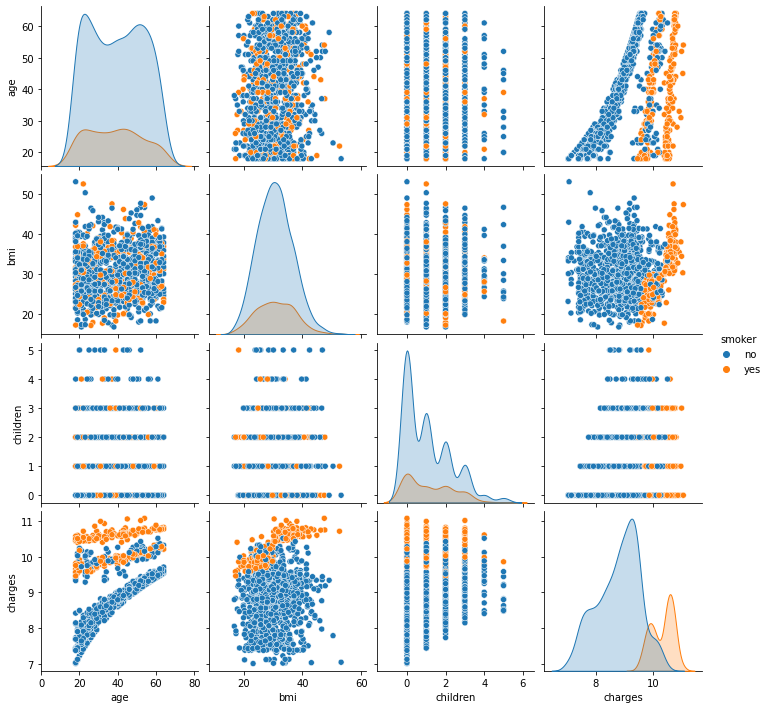

categorical feature: sex


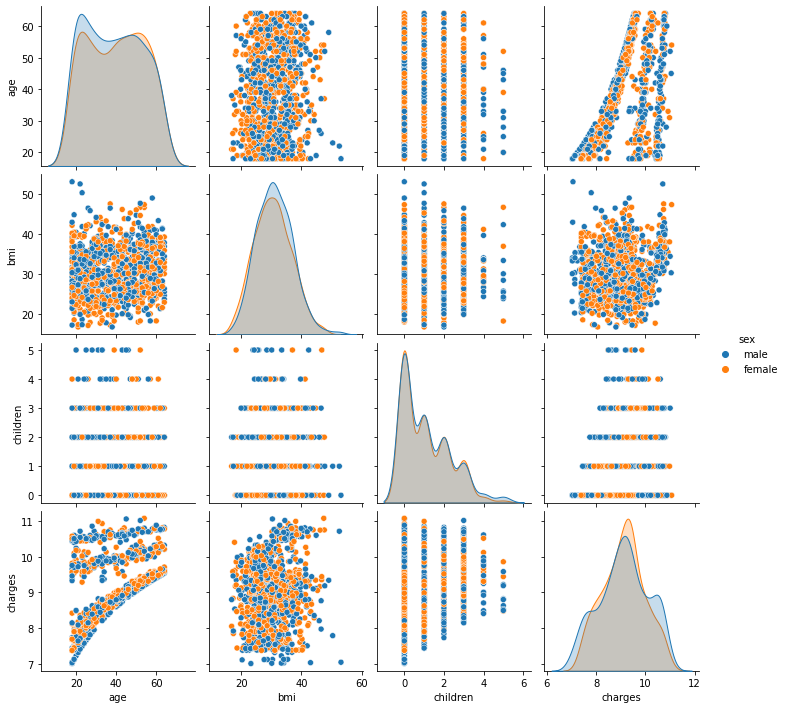

categorical feature: region


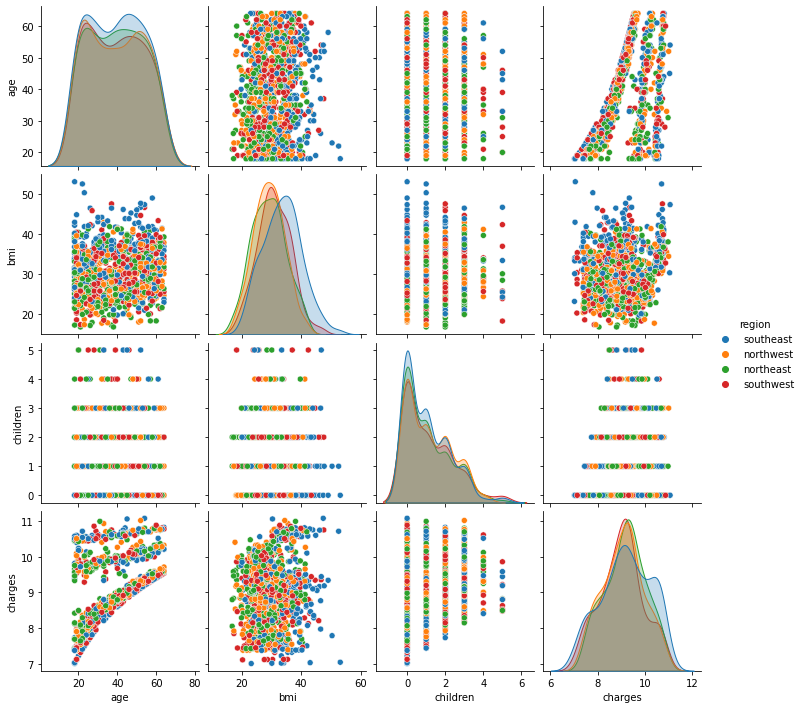

categorical feature: children


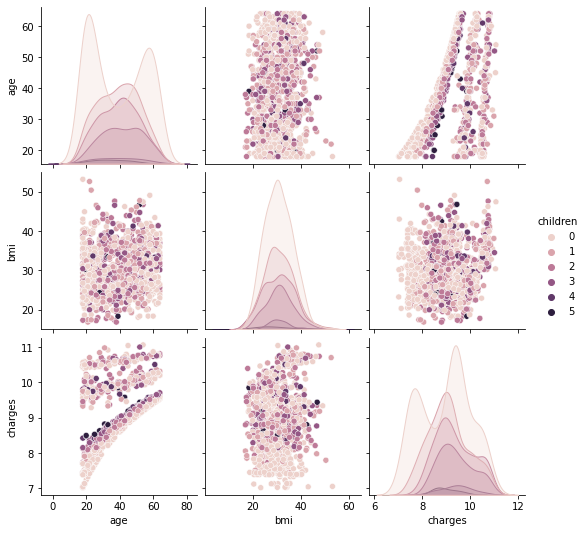

In [30]:
for cat in categorical_features:
    print(f'categorical feature: {cat}')
    sns.pairplot(df_train, hue=cat)
    plt.pause(0.1)

In [31]:
y_train = df_train.pop('charges')
y_test = df_test.pop('charges')

modeling

prepare some functions that are helpfull for model training and model comparison

In [32]:
class CustomColumnTransformer(BaseEstimator, TransformerMixin):
    '''
    switch between treating children as a categorical or numerical variable
    '''
    def __init__(self, categorical=True):
        self.categorical = categorical
        numeric_features = ['age', 'bmi']
        categorical_features = ['smoker', 'sex', 'region']
        if categorical:
            categorical_features.append('children')
        else:
            numeric_features.append('children')
        
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')
        
        self.preprocessor = ColumnTransformer(
            transformers=[('num', StandardScaler(), numeric_features), 
                          ('cat', categorical_transformer, categorical_features)])
    
    def fit(self, X, y=None):
        self.preprocessor.fit(X, y)
        return self
    
    def transform(self, X):
        return self.preprocessor.transform(X)

In [33]:
def get_pipeline(model):
    pipe = Pipeline(
    steps=[('preprocessor', CustomColumnTransformer()), ('model', model())]
    )
    return pipe

In [34]:
def train_model(pipe, param, num_cv=10):
    search = GridSearchCV(pipe, param, cv=num_cv, refit=True, verbose=0, n_jobs=1, scoring='neg_mean_squared_error')
    search.fit(df_train, y_train)
    display(list_results(search))
    y_pred = search.predict(df_test)
    evaluate_model_hue(y_test, y_pred, df_test, 'smoker', 'yes')
    return search

In [35]:
def list_results(search_cv):
    results = []
    for params, score in zip(search_cv.cv_results_['params'], search_cv.cv_results_['mean_test_score']):
        params['score'] = score
        results.append(params)
    return pd.DataFrame(results).sort_values(by='score', ascending=False)

In [37]:
def evaluate_model_hue(y, pred, df_val, col, label):
    y = np.expm1(y)
    pred = np.expm1(pred)
    print(f'{"MAE":<8} {mean_absolute_error(y, pred):.2f}')      
    print(f'{"RSME":<8} {np.sqrt(mean_squared_error(y, pred)):.2f}')
    print(f'{"R2 score":<8} {r2_score(y, pred):.2f}')
    f, axs = plt.subplots(1,2, figsize=(15,6))
    (y - pred).plot.hist(ax=axs[0], title='error')

    joined_data = pd.concat([pd.Series(index=df_val.index, data=y, name='true'), 
                             pd.Series(index=df_val.index, data=pred, name='pred'), 
                             df_val[col]], names=['true', 'pred', label], axis=1)
    
    A = joined_data[joined_data[col] == label]
    B = joined_data[joined_data[col] != label]
    
    axs[1].plot(A['true'], A['pred'], ls='None', marker='x', c='r', label=label)
    axs[1].plot(B['true'], B['pred'], ls='None', marker='x', c='b')
    
    axs[1].set_title(f'hue: {col}')
    axs[1].legend()
    axs[1].set_xlabel('target')
    axs[1].set_xlabel('prediction')

In [38]:
lm_pipe = get_pipeline(LinearRegression)

param_lm = [
    {
     'preprocessor__categorical': [True, False],
    }
]

,preprocessor__categorical,score
0,True,-0.210355
1,False,-0.210355


MAE      3355.19
RSME     6845.74
R2 score 0.64


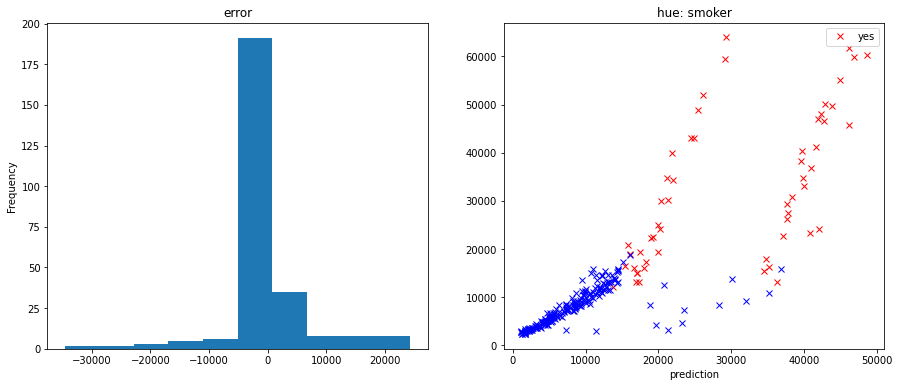

In [39]:
lm_pipe = train_model(lm_pipe, param_lm, num_cv=4)

In [40]:
ridge_pipe = get_pipeline(Ridge)

params_ridge = [
    {
     'preprocessor__categorical': [True, False],
      'model__alpha': [0.001, 0.01, 0.1, 1.0, 10]
    }
]

,model__alpha,preprocessor__categorical,score
6,1.000,True,-0.210238
7,1.000,False,-0.210238
4,0.100,True,-0.210341
5,0.100,False,-0.210341
2,0.010,True,-0.210354
3,0.010,False,-0.210354
0,0.001,True,-0.210355
1,0.001,False,-0.210355
8,10.000,True,-0.210726
9,10.000,False,-0.210726


MAE      3375.11
RSME     6903.29
R2 score 0.64


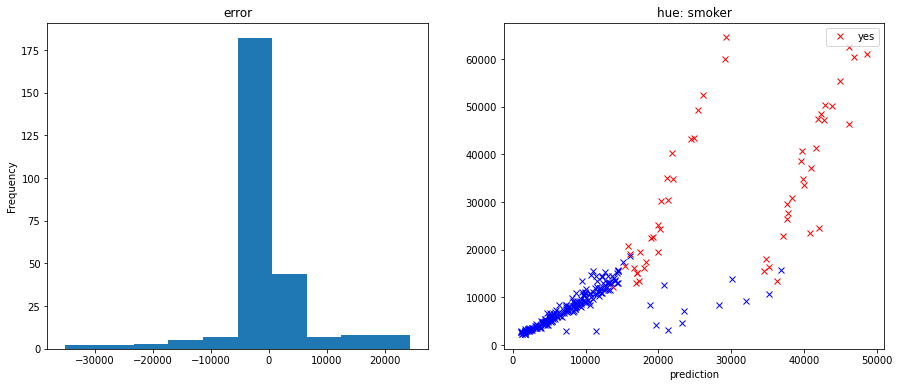

In [41]:
ridge_pipe = train_model(ridge_pipe, params_ridge, num_cv=4)

In [42]:
lasso_pipe = get_pipeline(Lasso)

params_lasso = [
    {
     'preprocessor__categorical': [True, False],
      'model__alpha': [0.001, 0.01, 0.1, 1.0, 10]
    }
]

,model__alpha,preprocessor__categorical,score
0,0.001,True,-0.210417
1,0.001,False,-0.210417
2,0.010,True,-0.214925
3,0.010,False,-0.214925
4,0.100,True,-0.303746
5,0.100,False,-0.303746
6,1.000,True,-0.850149
7,1.000,False,-0.850149
8,10.000,True,-0.850149
9,10.000,False,-0.850149


MAE      3368.36
RSME     6891.94
R2 score 0.64


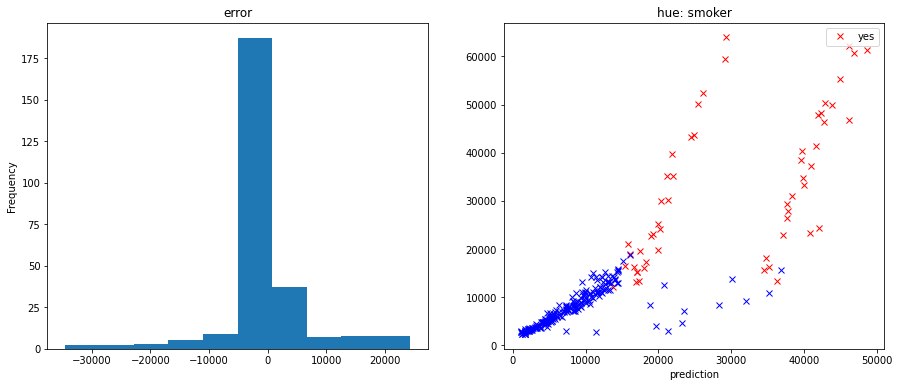

In [43]:
lasso_pipe = train_model(lasso_pipe, params_lasso, num_cv=4)

In [44]:
elastic_pipe = get_pipeline(ElasticNet)

params_elastic = [
    {
     'preprocessor__categorical': [True, False],
      'model__alpha': [0.001, 0.01, 0.1, 1.0, 10],
      'model__l1_ratio': [0.1, 0.5, 0.9]
    }
]

,model__alpha,model__l1_ratio,preprocessor__categorical,score
0,0.001,0.1,True,-0.210258
1,0.001,0.1,False,-0.210258
2,0.001,0.5,True,-0.210299
3,0.001,0.5,False,-0.210299
4,0.001,0.9,True,-0.210386
5,0.001,0.9,False,-0.210386
6,0.010,0.1,True,-0.210752
7,0.010,0.1,False,-0.210752
8,0.010,0.5,True,-0.212716
9,0.010,0.5,False,-0.212716


MAE      3372.58
RSME     6900.35
R2 score 0.64


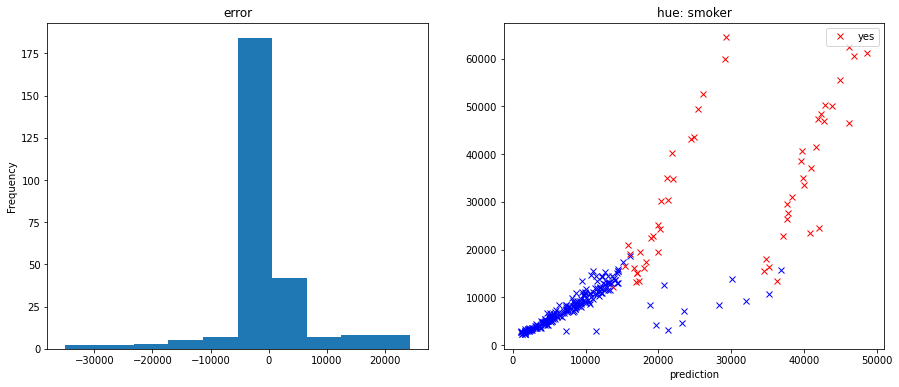

In [45]:
elastic_pipe = train_model(elastic_pipe, params_elastic, num_cv=4)

In [46]:
tree_pipe = get_pipeline(DecisionTreeRegressor)

params_tree = [
    {
     'preprocessor__categorical': [True, False],
     'model__max_depth': [4, 5, 6, 8],
      'model__min_samples_leaf': [10, 20, 25]
    }
]

,model__max_depth,model__min_samples_leaf,preprocessor__categorical,score
8,5,20,True,-0.155471
9,5,20,False,-0.155471
10,5,25,True,-0.156536
11,5,25,False,-0.156536
16,6,25,True,-0.156601
17,6,25,False,-0.156601
15,6,20,False,-0.156809
14,6,20,True,-0.156809
22,8,25,True,-0.156975
23,8,25,False,-0.156975


MAE      1904.76
RSME     4220.11
R2 score 0.87


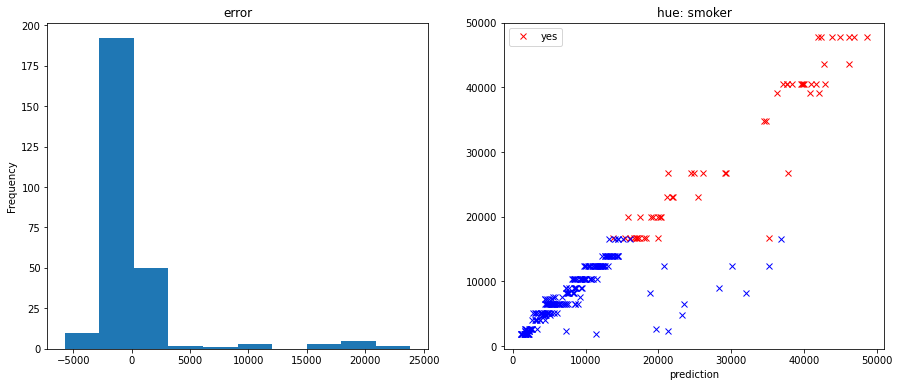

In [47]:
tree_pipe = train_model(tree_pipe, params_tree, num_cv=4)

In [48]:
rf_pipe = get_pipeline(RandomForestRegressor)

params_rf = [
    {
     'preprocessor__categorical': [True, False],
     'model__max_depth': [2, 3, 4, 5],
      'model__min_samples_leaf': [5, 10, 20],
     'model__n_estimators': [20, 50, 100, 200]
    }
]

,model__max_depth,model__min_samples_leaf,model__n_estimators,preprocessor__categorical,score
86,5,10,200,True,-0.150145
84,5,10,100,True,-0.150223
78,5,5,200,True,-0.150470
80,5,10,20,True,-0.150574
87,5,10,200,False,-0.150633
...,...,...,...,...,...
5,2,5,100,False,-0.227702
1,2,5,20,False,-0.228118
8,2,10,20,True,-0.228962
16,2,20,20,True,-0.228995


MAE      1827.53
RSME     4215.01
R2 score 0.87


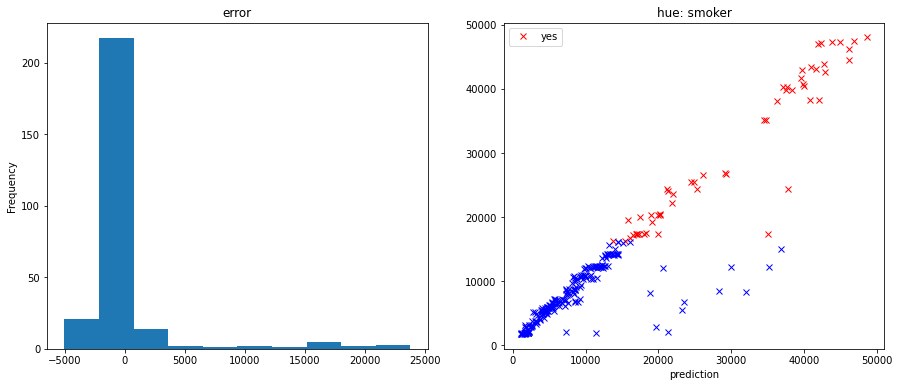

In [49]:
rf_pipe = train_model(rf_pipe, params_rf, num_cv=4)

The tree based models perform much better than the linear models. I select the simple tree, because it performs basically the same as the random forest, but it is a simpler model. For a tree we do not need to do feature scaling. Besides, it does not matter if we consider children as a categorical or numerical feature. Therefore we can simplify the pipeline.

In [90]:
def get_pipeline(model):
    categorical_features = ['smoker', 'sex', 'region']

    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(
        transformers=[('cat', categorical_transformer, categorical_features)], remainder='passthrough')

    pipe = Pipeline(
        steps=[('preprocessor', preprocessor), ('model', model())]
    )
    return pipe

In [91]:
def train(X_train, y_train):
    tree_pipe = get_pipeline(DecisionTreeRegressor)

    search = GridSearchCV(tree_pipe, params_tree, cv=4, refit=True, verbose=0, n_jobs=1,
                          scoring='neg_mean_squared_error')
    search.fit(X_train, y_train)

    return search.best_estimator_

In [92]:
    params_tree = [
        {
            'model__max_depth': [4, 5, 6, 8],
            'model__min_samples_leaf': [10, 20, 25]
        }
    ]

In [93]:
tree_pipe = train(df_train, y_train)

In [94]:
tree_pipe.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()

array(['smoker_no', 'smoker_yes', 'sex_female', 'sex_male',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'], dtype=object)

In [95]:
cols_out = list(tree_pipe.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()) + list(df_train.columns[tree_pipe.named_steps['preprocessor'].transformers_[1][2]])

In [96]:
print(export_text(tree_pipe.named_steps['model'], feature_names=cols_out))

|--- smoker_no <= 0.50
|   |--- bmi <= 30.01
|   |   |--- age <= 41.00
|   |   |   |--- age <= 29.50
|   |   |   |   |--- value: [9.73]
|   |   |   |--- age >  29.50
|   |   |   |   |--- value: [9.90]
|   |   |--- age >  41.00
|   |   |   |--- bmi <= 25.96
|   |   |   |   |--- value: [10.05]
|   |   |   |--- bmi >  25.96
|   |   |   |   |--- value: [10.19]
|   |--- bmi >  30.01
|   |   |--- age <= 30.50
|   |   |   |--- bmi <= 35.10
|   |   |   |   |--- value: [10.46]
|   |   |   |--- bmi >  35.10
|   |   |   |   |--- value: [10.57]
|   |   |--- age >  30.50
|   |   |   |--- age <= 50.50
|   |   |   |   |--- bmi <= 35.41
|   |   |   |   |   |--- value: [10.61]
|   |   |   |   |--- bmi >  35.41
|   |   |   |   |   |--- value: [10.69]
|   |   |   |--- age >  50.50
|   |   |   |   |--- value: [10.77]
|--- smoker_no >  0.50
|   |--- age <= 32.50
|   |   |--- children <= 0.50
|   |   |   |--- age <= 22.50
|   |   |   |   |--- region_northeast <= 0.50
|   |   |   |   |   |--- value: [7.52]
|

Can we find a simple explanation for the bad predictions?

In [97]:
y_pred = tree_pipe.predict(df_test)

<AxesSubplot:>

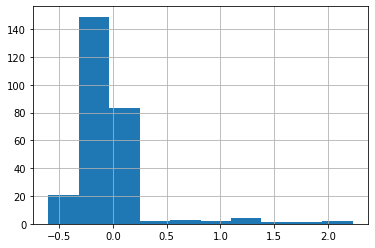

In [98]:
(y_test - y_pred).hist()

In [99]:
large_errors = (y_test - y_pred)[(y_test - y_pred) > 0.5].index

In [100]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [194]:
pd.concat([df_test.loc[large_errors], np.expm1(y_test.loc[large_errors])], axis=1)

,age,sex,bmi,children,smoker,region,charges
1211,39,male,34.100,2,no,southeast,23563.016180
644,43,male,35.310,2,no,southeast,18806.145470
525,18,female,33.880,0,no,southeast,11482.634850
242,55,female,26.800,1,no,southwest,35160.134570
1132,57,male,40.280,0,no,northeast,20709.020340
936,44,male,29.735,2,no,northeast,32108.662820
1206,59,female,34.800,2,no,southwest,36910.608030
987,45,female,27.645,1,no,northwest,28340.188850
476,24,male,28.500,0,yes,northeast,35147.528480
102,18,female,30.115,0,no,northeast,21344.846700


I don't see a pattern for the bad predictions. Probably the insurance is different for these people for reasons that are not given in the dataset.

simple code for testing the model API

In [102]:
import requests

In [103]:
url = 'http://192.168.178.36:9696/predict'
personal_info = {'age': 19,
                 'sex': 'female',
                 'bmi': 27.9,
                 'children': 0,
                 'smoker': 'yes',
                 'region': 'southwest'}

requests.post(url, json=personal_info).json()

{'charges': 29545.3340721382}

In [104]:
url = 'http://Karmufel.pythonanywhere.com/predict'
personal_info = {'age': 34,
                 'sex': 'female',
                 'bmi': 24,
                 'children': 0,
                 'smoker': 'no',
                 'region': 'southwest'}

requests.post(url, json=personal_info).json()

{'charges': 6331.089494751022}